In [1]:
import sys
sys.path.insert(1, "/home/fpei2/interp/fixed-point-finder")

In [2]:
import numpy as np
import torch
import h5py
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from pathlib import Path

/home/fpei2/miniconda3/envs/ttrnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from fixed_point_finder.finder import FixedPointFinder

No display found. Using non-interactive Agg backend.


In [4]:
%matplotlib inline

In [5]:
RUN_DIR = Path("/home/fpei2/interp/neural-population-dynamics/singlearea/lfads/runs/")
# MODEL_DIR = RUN_DIR / "murray_rec_pfc/231109_lfads_base_rs/run_model_158b2_00000/"
MODEL_DIR = RUN_DIR / "murray_rec_pfc/231112_lfads_odinlin_rs/run_model_7a9f5_00009/"
checkpoint_path = sorted(MODEL_DIR.rglob("*.ckpt"))[-1]
output_path = sorted(MODEL_DIR.rglob("*output*.h5"))[-1]

In [6]:
checkpoint = torch.load(checkpoint_path)

In [7]:
gen_cell_checkpoint = {key.split("decoder.rnn.cell.gen_cell.")[-1]: val for key, val in checkpoint["state_dict"].items() if "decoder.rnn.cell.gen_cell" in key}

In [8]:
from lfads_torch.modules.recurrent import ClippedGRUCell, MLPRNNCell, MLPwLinInputRNNCell, LowRankRNNCell

gen_cell_type = MLPwLinInputRNNCell
kwargs = dict(
    input_size=2,
    hidden_size=10, 
)

gen_cell = gen_cell_type(
    **kwargs
)

gen_cell.load_state_dict(gen_cell_checkpoint)

<All keys matched successfully>

In [9]:
device = "cpu"
gen_cell = gen_cell.to(device)

fpf = FixedPointFinder(
    rnn_cell=gen_cell,
    device=device,
    # tol_q=1e-6,
)

In [10]:
with h5py.File(output_path) as h5f:
    train_gen_states = h5f['train_gen_states'][()]

In [11]:
initial_states = fpf.sample_states(train_gen_states, n_inits=1000)
inputs = np.zeros((1000, 2))

In [12]:
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)

Searching for fixed points from 1000 initial states.
	Finding fixed points via joint optimization.

Iteration 100/5000
q = 2.36E-03 +/- 2.38E-03
dq = 1.95E-05 +/- 1.51E-05

Iteration 200/5000
q = 1.27E-03 +/- 1.51E-03
dq = 6.79E-06 +/- 8.19E-06

Iteration 300/5000
q = 7.84E-04 +/- 9.56E-04
dq = 2.98E-06 +/- 2.93E-06

Iteration 400/5000
q = 5.51E-04 +/- 7.71E-04
dq = 2.31E-06 +/- 2.05E-06

Iteration 500/5000
q = 2.46E-04 +/- 4.01E-04
dq = 4.26E-06 +/- 7.22E-06

Iteration 600/5000
q = 1.73E-05 +/- 3.43E-05
dq = 2.45E-07 +/- 3.15E-07

Iteration 700/5000
q = 5.82E-06 +/- 1.39E-05
dq = 5.63E-08 +/- 1.31E-07

Iteration 800/5000
q = 1.46E-06 +/- 3.69E-06
dq = 3.35E-08 +/- 8.17E-08

Iteration 900/5000
q = 8.31E-10 +/- 2.21E-09
dq = 1.67E-11 +/- 4.67E-11
	Optimization complete to desired tolerance.
Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 1000).
		fixed points: 0 outliers detected (of 1).
	Computing input and recurrent Jacobians at 1 unique fixed points.
	Deco

In [13]:
pca = PCA()
pca.fit(train_gen_states.reshape(-1, train_gen_states.shape[-1]))
print(np.cumsum(pca.explained_variance_ratio_)[:10])
train_gen_states_pca = pca.transform(train_gen_states.reshape(-1, train_gen_states.shape[-1]))
train_gen_states_pca = train_gen_states_pca.reshape(train_gen_states.shape[0], train_gen_states.shape[1], -1)

[0.9338726  0.99208697 0.99720624 0.99880021 0.99956687 0.99986838
 0.99994255 0.99997882 0.9999901  1.        ]


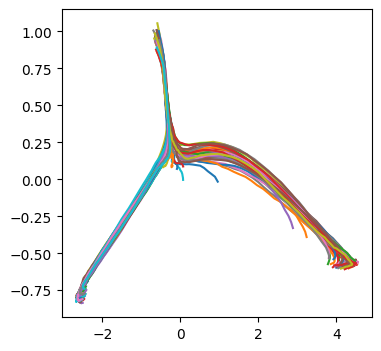

In [14]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

plot_trials = 100
for i in range(plot_trials):
    ax.plot(
        train_gen_states_pca[i, :, 0],
        train_gen_states_pca[i, :, 1],
    )

In [15]:
fixed_points_pca = pca.transform(unique_fps.xstar)

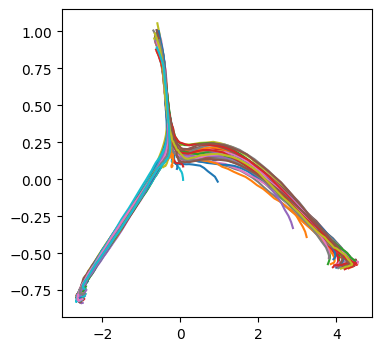

In [19]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

plot_trials = 100
for i in range(plot_trials):
    ax.plot(
        train_gen_states_pca[i, :, 0],
        train_gen_states_pca[i, :, 1],
    )

ax.scatter(fixed_points_pca[:, 0], fixed_points_pca[:, 1])

In [20]:
unique_fps.xstar

array([[-0.01027533, -0.47965783, -0.6949459 , -0.43908072,  0.13109368,
         0.38753372,  0.45512682,  0.09614632, -0.28744322,  0.3612655 ]],
      dtype=float32)